Need to install numpy-stl:
__pip install numpy-stl__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from stl import mesh
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import sympy as sp
import pandas as pd

from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_kinematics import KDLKinematics


# Load URDF

In [2]:
URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/urdf/'
urdf_model     = URDF_DIR + 'pavlov_mini.urdf'\

urdf_str = open(urdf_model, 'r').read()
robot_urdf = URDF.from_xml_string(urdf_str)


# Forward kinematics FR

Inverse Kinematic Analysis Of A Quadruped Robot

In [3]:
def getJointPositions(robot_urdf, leg, angles):
    
    hip_ref       = 'hip_{:s}_ref'   .format(leg)
    femur_link    = 'femur_{:s}_link'.format(leg)
    tibia_link    = 'tibia_{:s}_link'.format(leg)
    feet_link     = 'feet_{:s}'      .format(leg)
    
    kdl_femur = KDLKinematics(robot_urdf, hip_ref, femur_link)
    kdl_tibia = KDLKinematics(robot_urdf, hip_ref, tibia_link)
    kdl_feet  = KDLKinematics(robot_urdf, hip_ref, feet_link )
    
    pose_femur = kdl_femur.forward(angles[0:2])
    pose_tibia = kdl_tibia.forward(angles)
    pose_feet  = kdl_feet .forward(angles)

    
    pos_femur  = [pose_femur[0, 3], pose_femur[1, 3], pose_femur[2, 3]]
    pos_tibia  = [pose_tibia[0, 3], pose_tibia[1, 3], pose_tibia[2, 3]]
    pos_feet   = [pose_feet[0, 3],  pose_feet[1, 3],  pose_feet[2, 3]]
    
    return np.array([[0,0,0], pos_femur, pos_tibia, pos_feet])

    
    
joint_pos = getJointPositions(robot_urdf, 'fl', [0.5,0.3,0.3])
print(joint_pos)

[[ 0.          0.          0.        ]
 [ 0.          0.03685847  0.02013587]
 [-0.03349722  0.08494795 -0.07698555]
 [-0.09525781  0.11549447 -0.16316596]]


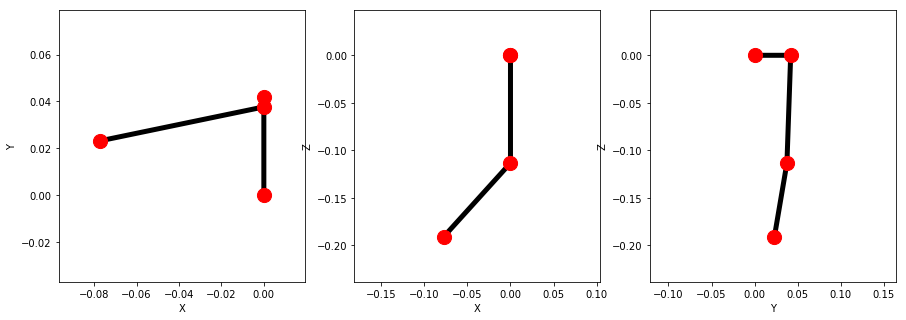

In [4]:
def plotLegFromJointAngles(angles_deg, axes, leg = 'fl', range_axis_factor=1.5, alpha = 1, transform = np.identity(4)):
    angles = np.array(angles_deg)*np.pi/180
    joint_pos = getJointPositions(robot_urdf, leg, angles)
    
    joint_pos_tf = []
    for i in range(len(joint_pos)):
        joint = np.array(list(joint_pos[i]) + [1])
        joint_pos_tf.append(  transform.dot(joint)  )
        
    joint_pos_tf = np.array(joint_pos_tf)
    
    joint0 = joint_pos_tf[0][:3]
    joint1 = joint_pos_tf[1][:3]
    joint2 = joint_pos_tf[2][:3]
    joint3 = joint_pos_tf[3][:3]
    


    forward_kin = np.array([joint0, joint1, joint2, joint3])


    plots = [[forward_kin[:,0], forward_kin[:,1]], 
             [forward_kin[:,0], forward_kin[:,2]], 
             [forward_kin[:,1], forward_kin[:,2]]]
    plots_name = [['X', 'Y'], ['X', 'Z'], ['Y', 'Z']]

    for i in range(3):
        axes[i].plot(plots[i][0], plots[i][1], color ='black', linewidth = 5, alpha = alpha)
        axes[i].scatter(plots[i][0], plots[i][1], color ='red', s = 200, zorder = 2.5, alpha = alpha)




        range_axis = [np.max(plots[i][0]) - np.min(plots[i][0]), 
                      np.max(plots[i][1]) - np.min(plots[i][1])]
        
        if range_axis_factor > 0:
            range_axis = np.max(range_axis)*range_axis_factor

            mean_val_x = ( np.max(plots[i][0]) + np.min(plots[i][0]))/2 
            mean_val_y = ( np.max(plots[i][1]) + np.min(plots[i][1]))/2 

            axes[i].set_xlim(-range_axis/2 + mean_val_x, range_axis/2 + mean_val_x)
            axes[i].set_ylim(-range_axis/2 + mean_val_y, range_axis/2 + mean_val_y)
        axes[i].set_xlabel(plots_name[i][0])
        axes[i].set_ylabel(plots_name[i][1])

        
fig, axes = plt.subplots(1,3,figsize = (15,5))

leg = 'fl'


plotLegFromJointAngles([0,0, 45], axes, leg = leg)

# Leg workspace

In [5]:
def getJointLimits(robot_urdf, leg = 'fl'):
    hip1 = [0,0]
    hip2 = [0,0]
    knee = [0,0]
    
    
    for joint in robot_urdf.joints:
        if joint.name == 'hip1_{:s}'.format(leg):
            hip1 = [joint.limit.lower, joint.limit.upper]
        
        if joint.name == 'hip2_{:s}'.format(leg):
            hip2 = [joint.limit.lower, joint.limit.upper]
        
        if joint.name == 'knee_{:s}'.format(leg):
            knee = [joint.limit.lower, joint.limit.upper]
            
    return np.array([hip1, hip2, knee])

joint_limits = getJointLimits(robot_urdf)
print(joint_limits)

[[-1.5708   1.5708 ]
 [-1.5708   0.7854 ]
 [-1.22173  1.5708 ]]


In [78]:
num_points = 20
hip1_angles_range = np.linspace(joint_limits[0,0], joint_limits[0,1], num_points)
hip2_angles_range = np.linspace(joint_limits[1,0], joint_limits[1,1], num_points)
knee_angles_range = np.linspace(joint_limits[2,0], joint_limits[2,1], num_points)

feet_region = np.zeros([3, num_points**3])

for i in range(num_points):
    for j in range(num_points):
        for k in range(num_points):
            angles = [hip1_angles_range[i], hip2_angles_range[j], knee_angles_range[k]]
            joint_pos = getJointPositions(robot_urdf, 'fl', angles)
            feet_region[0, i*num_points**2 + j*num_points + k] = joint_pos[3,0]
            feet_region[1, i*num_points**2 + j*num_points + k] = joint_pos[3,1]
            feet_region[2, i*num_points**2 + j*num_points + k] = joint_pos[3,2]


In [96]:
def plotSphere(axes, pos, radius, alpha=1, color = 'red'):
    pos_ax = [[pos[0], pos[1]], [pos[0], pos[2]], [pos[1], pos[2]]]
    for i in range(3):
        circle = plt.Circle((pos_ax[i][0], pos_ax[i][1]), radius, alpha = alpha, color = color)
        axes[i].add_artist(circle)
        axes[i].set_aspect('equal')


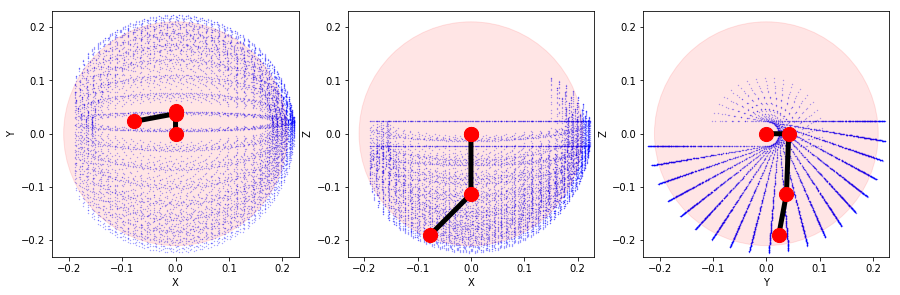

In [106]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
axes[0].scatter(feet_region[0], feet_region[1], s = 0.1, color='blue', alpha = 0.5)
axes[1].scatter(feet_region[0], feet_region[2], s = 0.1, color='blue', alpha = 0.5)
axes[2].scatter(feet_region[1], feet_region[2], s = 0.1, color='blue', alpha = 0.5)
plotLegFromJointAngles([0,0, 45], axes, range_axis_factor=0)


## Manually set region. Smaller than computed region to ensure reachability
radius = 0.21
plotSphere(axes, [0,0,0], radius, alpha= 0.1)
for i in range(3):
    axes[i].set_xlim(-radius*1.1, radius*1.1)
    axes[i].set_ylim(-radius*1.1, radius*1.1)

# Inverse kinematics

Based on [1]

___________________________________
[1] __Sen MA, et al. Inverse Kinematic Analysis Of A Quadruped Robot. International journal of scientific & technology research. 2017 Sep;6(9):285-9.__

### Obtain leg dimentions from URDF model

In [6]:
def getLegDimensions(robot_urdf):
    
    dimentions = {}
    leg_names   = ['fl', 'fr', 'bl', 'br']
    joint_names = ['hip1', 'hip2', 'knee', 'feet']
    
    for name in leg_names:
        dimentions[name] = {}

    
    for joint in robot_urdf.joints:
        for joint_name in joint_names:
            if joint_name in joint.name:
                name = joint.name.split('_')[1]
                xyz = np.array( joint.origin.xyz, dtype = 'float32' )
                dimentions[name][joint_name] = xyz


    dimentions_leg = {}
    for key in dimentions:
        dimentions_leg[key] = np.array(  [dimentions[key][j] for j in joint_names] )

    return dimentions_leg




leg_dimentions   = getLegDimensions(robot_urdf)
for key in leg_dimentions:
    print(key)
    print(leg_dimentions[key])
    print("")

bl
[[ 0.       0.       0.     ]
 [ 0.       0.042    0.     ]
 [ 0.      -0.00436 -0.11335]
 [ 0.      -0.01451 -0.10938]]

fr
[[ 0.       0.       0.     ]
 [ 0.      -0.042    0.     ]
 [ 0.       0.00436 -0.11335]
 [ 0.       0.01451 -0.10938]]

fl
[[ 0.       0.       0.     ]
 [ 0.       0.042    0.     ]
 [ 0.      -0.00436 -0.11335]
 [ 0.      -0.01451 -0.10938]]

br
[[ 0.       0.       0.     ]
 [ 0.      -0.042    0.     ]
 [ 0.       0.00436 -0.11335]
 [ 0.       0.01451 -0.10938]]



In [69]:
def plotPos(axes, pos, s, color):
    pos_ax = [[pos[0], pos[1]], [pos[0], pos[2]], [pos[1], pos[2]]]
    for i in range(3):
        axes[i].scatter(pos_ax[i][0], pos_ax[i][1], s = s, color = color)

def plotLine(axes, pos0, pos1, linewidth, color):
    pos_ax = [[  [pos0[0], pos1[0]],   [pos0[1], pos1[1]]  ],
              [  [pos0[0], pos1[0]],   [pos0[2], pos1[2]]  ],
              [  [pos0[1], pos1[1]],   [pos0[2], pos1[2]]  ]]

    for i in range(3):
        axes[i].plot(pos_ax[i][0], pos_ax[i][1], linewidth = linewidth, color = color)
        
        

        
def changeOriginAngles(ang_array, factor = np.pi):
    rev = np.floor_divide(ang_array, factor)
    offset = np.remainder(rev,2)
    ang_array = ang_array - 2*factor*(np.floor_divide(rev,2) + offset)
    return ang_array

def inverseKinematics(leg_dimentions, leg, feet_pos, axes):

    L0 = np.abs(np.sum(leg_dimentions[leg][:,1], axis=0))  # Offset of the feet in the y axis
    L1 = np.abs(leg_dimentions[leg][2,2])                  # Length of the femur in the z axis
    L2 = np.abs(leg_dimentions[leg][3,2])                  # Length of the tibia in the z axis
    
    [x, y, z] = feet_pos
    
    z_corr_2 = y**2 + z**2 - L0**2
    D        = float(x**2 + y**2 + z**2 - L0**2 - L1**2 - L2**2)/(2*L1*L2)

    if D > 1 or z_corr_2 < 0:                             # If D > 1, or z_corr_2 < 0, reachability is not possible
        return False, np.array([0,0,0])                   #     return [0,0,0] angles
    
    z_corr   = np.sqrt( z_corr_2 )


    
    if D > 1:                                              # If D > 1, reachability is not possible
        return False, np.array([0,0,0])

    if 'l' in leg:                                         # Left leg 
        a = np.pi - np.arctan2(-z, y) - np.arctan2(z_corr, -L0)     # hip1 angle
    
    else:                                                  # Right leg
        a = - (- np.arctan2(z, y) - np.arctan2(z_corr, -L0) )      # hip1 angle 

        
    #c = np.arctan2( np.sqrt(1 - D**2),  D )                    # knee angle, inverted knee angle
    c = np.arctan2( - np.sqrt(1 - D**2),  D )                   # knee angle

    
    # hip2 angle
    b = -np.pi+ np.arctan2(  x, -z_corr  ) - np.arctan2(  L2*np.sin(c), L1 + L2*np.cos(c)  ) 

    angles = np.array([a,b,c])
    return True, angles



Angles (degrees): [ -48.3, -293.5, -68.6]


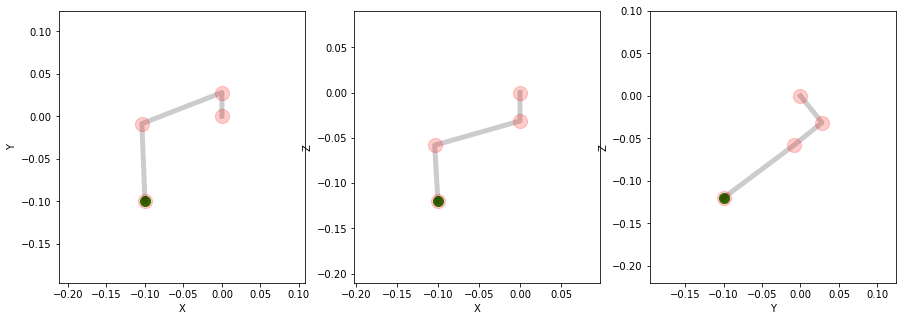

In [70]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
feet_pos = [-0.1, -0.1,-0.12]
leg      = 'fl'

hr, angles = inverseKinematics(leg_dimentions, leg, feet_pos, axes)
if not hr:
    print("Error: Could not compute IK")

print('Angles (degrees): [ {:.1f}, {:.1f}, {:.1f}]'.format(angles[0]*180/np.pi, angles[1]*180/np.pi, angles[2]*180/np.pi))
    
plotLegFromJointAngles(angles*180/np.pi, axes, leg = leg, alpha=0.2, range_axis_factor=2.5)
plotPos(axes, feet_pos, s = 100, color = 'green')

Angles (degrees): [ -14.5, 39.5, -80.8]


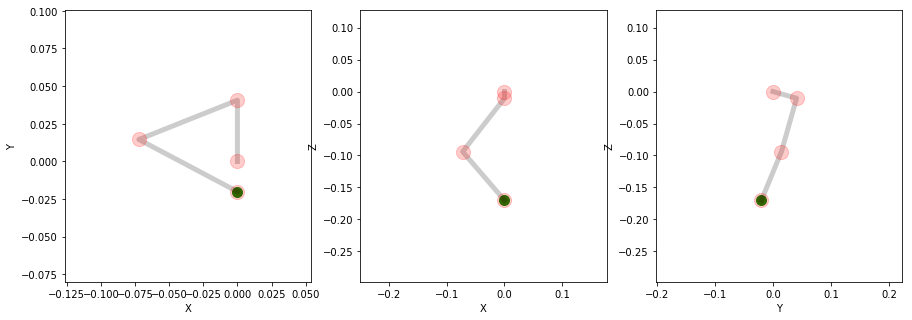

In [72]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
feet_pos = [0, -0.02,-0.17]
leg      = 'fl'

hr, angles = inverseKinematics(leg_dimentions, leg, feet_pos, axes)
if not hr:
    print("Error: Could not compute IK")

print('Angles (degrees): [ {:.1f}, {:.1f}, {:.1f}]'.format(angles[0]*180/np.pi, angles[1]*180/np.pi, angles[2]*180/np.pi))
    
plotLegFromJointAngles(angles*180/np.pi, axes, leg = leg, alpha=0.2, range_axis_factor=2.5)
plotPos(axes, feet_pos, s = 100, color = 'green')

# Body kinematics

In [75]:
def getTfMatrices(pos, euler_ang):
    [x,y,z]            = pos
    [roll, pit, yaw] = -np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0,             0],
                   [0,            np.cos(roll),   -np.sin(roll), 0],
                   [0,            np.sin(roll),   np.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = np.array([[np.cos(yaw),  0,              np.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-np.sin(yaw), 0,              np.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = np.array([[np.cos(pit), -np.sin(pit),   0,             0],
                   [np.sin(pit),  np.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = np.array([[0, 0, 0, x],
                      [0, 0, 0, y],
                      [0, 0, 0, z],
                      [0, 0, 0, 0]])
    
    Rxyz = np.dot(Rz,Ry).dot(Rx)
    
    return Rxyz, T_pos
    
        
Rxyz, T_pos = getTfMatrices([0,0,0.2], [0,0,0.2])
print(Rxyz)

[[ 0.98006658  0.         -0.19866933  0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.19866933  0.          0.98006658  0.        ]
 [ 0.          0.          0.          1.        ]]


In [9]:
def getHipRefDimentions(robot_urdf):
    leg_names   = ['fl', 'fr', 'bl', 'br']
    
    dimentions = {}
    for name in leg_names:
        dimentions[name] = {}

    
    for joint in robot_urdf.joints:
        for leg in leg_names:
            if joint.name == '{:s}_ref'.format(leg):
                xyz = np.array( joint.origin.xyz, dtype = 'float32' )
                dimentions[leg] = xyz
                
                
                
    
    return dimentions
    
            
hipref_dimentions = getHipRefDimentions(robot_urdf)

for key in hipref_dimentions:
    print(key)
    print(hipref_dimentions[key])
    print("")

bl
[-0.10136  0.05355  0.     ]

fr
[ 0.10136 -0.05355  0.     ]

fl
[0.10136 0.05355 0.     ]

br
[-0.10136 -0.05355  0.     ]



In [76]:
import time 

def getFeetPositionsFromBodyPose(pos, euler_angles):
    Rxyz, T_pos = getTfMatrices(pos, euler_angles)
    hipref_dimentions = getHipRefDimentions(robot_urdf)
    
    
    # Pose of leg reference from body frame of reference
    T_hip_fl = np.array([[ 1, 0, 0, hipref_dimentions['fl'][0]],
                         [ 0, 1, 0, hipref_dimentions['fl'][1]],
                         [ 0, 0, 1, hipref_dimentions['fl'][2]],
                         [ 0, 0, 0, 1                         ]])
    
    T_hip_fr = np.array([[ 1, 0, 0, hipref_dimentions['fr'][0]],
                         [ 0, 1, 0, hipref_dimentions['fr'][1]],
                         [ 0, 0, 1, hipref_dimentions['fr'][2]],
                         [ 0, 0, 0, 1                         ]])
    
    T_hip_bl = np.array([[ 1, 0, 0, hipref_dimentions['bl'][0]],
                         [ 0, 1, 0, hipref_dimentions['bl'][1]],
                         [ 0, 0, 1, hipref_dimentions['bl'][2]],
                         [ 0, 0, 0, 1                         ]])
    
    T_hip_br = np.array([[ 1, 0, 0, hipref_dimentions['br'][0]],
                         [ 0, 1, 0, hipref_dimentions['br'][1]],
                         [ 0, 0, 1, hipref_dimentions['br'][2]],
                         [ 0, 0, 0, 1                         ]])

    # pose of each leg reference from the ground frame of reference, given rotation and translation of body
    ref_pose = {}
    ref_pose['fl'] = Rxyz.dot(T_hip_fl) + T_pos
    ref_pose['fr'] = Rxyz.dot(T_hip_fr) + T_pos
    ref_pose['bl'] = Rxyz.dot(T_hip_bl) + T_pos
    ref_pose['br'] = Rxyz.dot(T_hip_br) + T_pos

    
    # Compute the pose of the feet from the leg reference
    feet_pose = {}    
    feet_pose['fl'] = np.linalg.inv(ref_pose['fl']).dot( T_hip_fl )
    feet_pose['fr'] = np.linalg.inv(ref_pose['fr']).dot( T_hip_fr )
    feet_pose['bl'] = np.linalg.inv(ref_pose['bl']).dot( T_hip_bl )
    feet_pose['br'] = np.linalg.inv(ref_pose['br']).dot( T_hip_br ) 
    
    feet_pos = {}
    for key in ref_pose:
        feet_pos[key] = np.array( [feet_pose[key][0, 3], feet_pose[key][1, 3], feet_pose[key][2, 3]] ) 

    return feet_pos, ref_pose
    
    
tstart = time.time()
feet_pos, ref_tf = getFeetPositionsFromBodyPose([0,0,0.1], [0,0,0])
print('Time elapsed in computing body IK: {:.2f} sec'.format(time.time() - tstart))

for key in feet_pos:
    print(key)
    print(feet_pos[key])
    print("")
    


Time elapsed in computing body IK: 0.00 sec
bl
[ 0.   0.  -0.1]

fr
[ 0.   0.  -0.1]

fl
[ 0.   0.  -0.1]

br
[ 0.   0.  -0.1]



In [64]:
def IK_body(pos, euler_ang):
    hipref_dimentions = getHipRefDimentions(robot_urdf)
    feet_pos, ref_pose = getFeetPositionsFromBodyPose(pos, euler_ang)
    
    angles = {}
    hr = True
    for leg in feet_pos:

        r, ang = inverseKinematics(leg_dimentions, leg, feet_pos[leg]  , None)
        
        if not r:
            hr = False
        
        angles[leg] = ang
        
    return hr, angles, ref_pose




def plotPoseRobot(pos, euler_ang):
    hr, angles, ref_pose = IK_body(pos, euler_ang)
    if not hr:
        print("Error: cannot compute IK body")
    
    fig, axes = plt.subplots(1,3,figsize = (15,5))

    T_pos = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0.2],
                      [0, 0, 0, 1]])
    
    
    for leg in hipref_dimentions:
        
        
        angle_joints = angles[leg]*180/np.pi  # rad to degrees
        
        ### Plot each leg of the robot in red
        plotLegFromJointAngles(angle_joints, axes, range_axis_factor=0, leg = leg, alpha = 0.2 , transform = ref_pose[leg])
        
        ### Plot the target position of each feet in blue, 
        #   if everything works, it should coincide with the robot feet
        
        plotPos(axes, hipref_dimentions[leg], color = 'blue', s = 50)


    plotPos(axes, pos, color = 'blue', s = 50)
    return hr, angles

Leg bl Joint angles: [-13.4, 62.0, -128.2]
Leg fr Joint angles: [13.4, 62.0, -128.2]
Leg fl Joint angles: [-13.4, 62.0, -128.2]
Leg br Joint angles: [13.4, 62.0, -128.2]


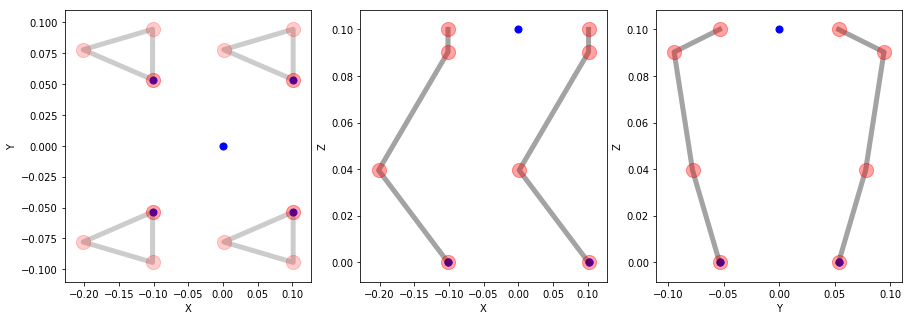

In [77]:
hr, angles = plotPoseRobot([0,0,0.1], [0,0,0])
for leg in angles:
    print('Leg {:s} Joint angles: [{:.1f}, {:.1f}, {:.1f}]'.format(leg, angles[leg][0] * 180 / np.pi, angles[leg][1] * 180 / np.pi,
                                                               angles[leg][2] * 180 / np.pi))

Leg bl Joint angles: [-2.9, 64.8, -134.4]
Leg fr Joint angles: [23.0, 59.1, -121.9]
Leg fl Joint angles: [-2.9, 64.8, -134.4]
Leg br Joint angles: [23.0, 59.1, -121.9]


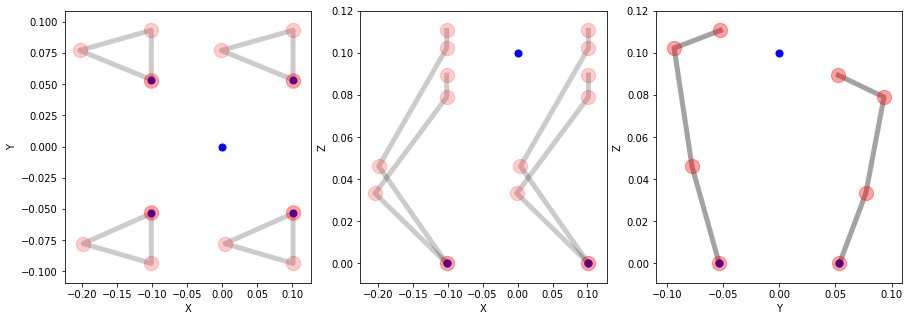

In [66]:
hr, angles = plotPoseRobot([0,0,0.1], [0.2,0,0])
for leg in angles:
    print('Leg {:s} Joint angles: [{:.1f}, {:.1f}, {:.1f}]'.format(leg, angles[leg][0] * 180 / np.pi, angles[leg][1] * 180 / np.pi,
                                                               angles[leg][2] * 180 / np.pi))

Leg bl Joint angles: [-17.3, -279.4, -139.9]
Leg fr Joint angles: [11.3, -292.9, -116.1]
Leg fl Joint angles: [-11.3, -292.9, -116.1]
Leg br Joint angles: [17.3, -279.4, -139.9]


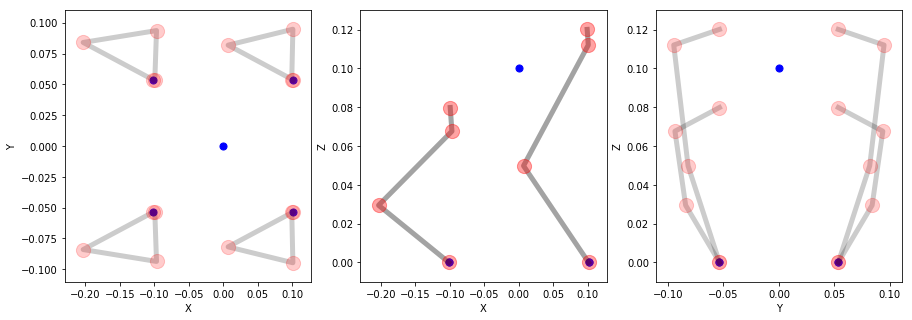

In [67]:
hr, angles = plotPoseRobot([0,0,0.1], [0,0,0.2])
for leg in angles:
    print('Leg {:s} Joint angles: [{:.1f}, {:.1f}, {:.1f}]'.format(leg, angles[leg][0] * 180 / np.pi, angles[leg][1] * 180 / np.pi,
                                                               angles[leg][2] * 180 / np.pi))

### Test pavlov mini kinematics in ROS

In [110]:
import os
os.system("roslaunch pavlov_mini_control test_kinematics.launch")

2

# Feet path spline

In [1167]:
def getMaximumVelocity(robot_urdf, leg = 'fl'):
    vel = []
    for joint in robot_urdf.joints:
        if leg in joint.name and joint.type == 'revolute':
            vel.append( joint.limit.velocity )
    return np.min(vel)

max_vel = getMaximumVelocity(robot_urdf, leg = 'fl')
print('Maximum velocity for servos {:.1f} degrees/s'.format(max_vel*180/np.pi))

Maximum velocity for servos 60.0 degrees/s


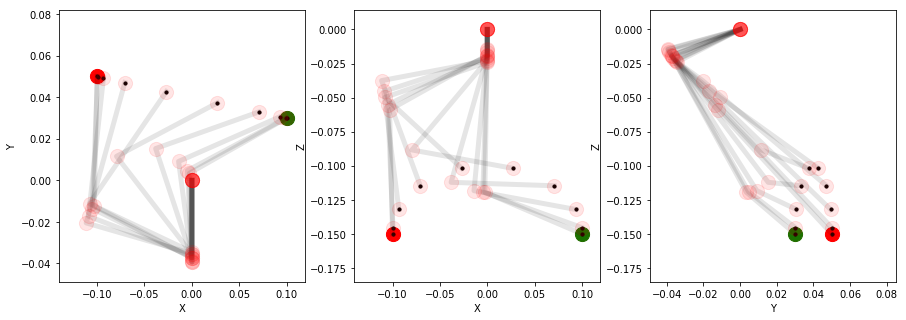

In [1477]:
def plotPath(axes, path, s, color):
    pos_ax = [[path[0], path[1] ],
              [path[0], path[2] ],
              [path[1], path[2] ]]

    for i in range(3):
        axes[i].scatter(pos_ax[i][0], pos_ax[i][1], s = s, color = color)
        
        

def define_path(p0, pf, period, height, vel = 60, num_points = 20):
    phi = np.arctan2(pf[1] - p0[1], pf[0] - p0[0]  )
    d = np.linalg.norm(pf - p0)
    
    plt.figure()
    t = np.linspace(0, np.pi, num_points)
    t = 0.5*np.pi*( np.cos(t) + 1)          # Use S curve (cos(t)) for acceleration by creating more points
                                            # in the path at the begining and at the end

    x = p0[0] + 0.5*d*( np.cos(t) + 1)*np.cos(phi)
    y = p0[1] + 0.5*d*( np.cos(t) + 1)*np.sin(phi)
    z = p0[2] + height*np.sin(t)
    
    return np.array([x,y,z])


    
num_points = 10
p0 = np.array([-0.1, 0.05, -0.15])
p1 = np.array([0.1, 0.03, -0.15])
leg = 'fr'

path = define_path(p0, p1, period=0.1, height = 0.05, vel = max_vel, num_points = num_points)


fig, axes = plt.subplots(1,3,figsize = (15,5))
plotPos(axes, p0, color='red', s = 200)
plotPos(axes, p1, color='green', s = 200)
plotPath(axes, path, color = 'black', s = 10)


leg_plots = 10
for i in range(leg_plots):
    ix = int((float(i)/(leg_plots-1))*(num_points-1))
    feet_pos = path[:, ix]
    hr, angles = inverseKinematics(leg_dimentions, leg, path[:, ix], axes)
    plotLegFromJointAngles(angles*180/np.pi, axes, leg = leg, alpha=0.1, range_axis_factor=0)


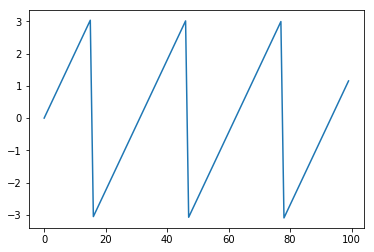

In [32]:
def limitAngles(ang):
    return (ang + np.pi) % (2 * np.pi) - np.pi
    

phase = np.linspace(0, 20, 100)

ang = limitAngles(phase)

plt.plot(ang)